<a href="https://colab.research.google.com/github/Elkebiglr/8dm40-machine-learning/blob/Elke/Copy_of_Group_5_Week_5_GAN_practical_share.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data synthesis using generative adversarial networks (GANs)

In this practical session we will build and train generative adversarial networks that are able to generate images.

This is a Google Colab notebook, which is mostly the same as a Jupyter notebook. This means that you can run the code in a cell by selecting the cell and pressing Shift+Enter. We will run everything in the cloud, so you don't need a fancy computer or an expensive GPU for this exercise. We are going to use GPUs that Google Cloud provides for free. To do this, go to Edit --> Notebook settings and select GPU as Hardware accelerator. Then, in the top right of this screen select 'CONNECT' --> 'Connect to hosted runtime'

We are going to import some of the packages that we will need in this exercise (by running the cell below)

The documentation for key packages can be found online: <br>
For numpy: https://docs.scipy.org/doc/numpy-dev/user/quickstart.html <br>
For matplotlib: http://matplotlib.org/api/pyplot_api.html <br>
For Keras: https://keras.io/ <br>
For random: https://docs.python.org/2/library/random.html <br>

In [0]:
import pickle
import gzip
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc
from matplotlib import pylab
from IPython import display

import tensorflow as tf
import keras
keras.backend.set_image_data_format('channels_first')

import time
import random
from google.colab import files
from google.colab import widgets
random.seed(0)

# Check whether we're using a GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


Found GPU at: /device:GPU:0


## Small steps
Before moving on to generating images, we will start with a simple 1D problem. We will assume that there is a data set of real samples that are drawn from a normal distribution with a particular mean value (the black dotted line below). These samples are in the sample domain *x*. 

The generator network does not know anything about the distribution of the real samples in the sample domain *x*, but will try to come up with a transformation that maps random noise from a distribution *z* to samples that seem to come from the real sample distribution (the green line below). This is very similar to what we have looked at in the lecture.

<img src="https://cs.stanford.edu/people/karpathy/gan/gan.png">

For this, we will define two neural networks that play a game:
*   The discriminator will learn to distinguish real and fake samples in *z*
*   The generator will generate fake samples in *z* that the discriminator cannot discriminate

First, we determine the mean value of the normal distribution from which **real** samples will be drawn in the sample domain *x*. In addition, we define the dimensionality of the normal distribution *z* from which noise samples to the generator will be drawn, i.e. the latent space. This will be 1 for now.

In [0]:
real_mean = 8
latent_dim = 1

Next, we define our discriminator and generator. These are both very simple networks.

**Question** How many layers does each of these networks have? 

**Answer** *The the discriminator and generator both have one hidden layer and one output layer.*

**Question** Can you find out how many trainable parameters the networks have?

**Answer** *Both networks have the same structure, so the same amount of trainable parameters. The latent space is 1 dimensional and will divide over 32 neurons in the first dense layers, so has (1+1)32 = 64 trainable parameters, with the bias factor included. The second dense layer consists of 1 neuron, so has (32+1)1 = 33 trainable parameters. This makes a total of 97 trainable parameters*


**Question** What are the activation functions of both networks? Why are they like this? 

**Answer** *The activation for the hidden layer of both the generator and discriminator is the LeakyReLU activation function.
The normal ReLU function is linear for values greater than zero and returns zero for negative values, so it is a nonlinear function. The LeakyReLU is quite similar, but for negative values it will be multiplied by 0.01. So while learning, a small gradient will remain even for negative values. If you were to use a regular ReLu, for the values below zero, the gradient would be zero too and all learning would be blocked.
For the discriminator, the activation for the output layer is the sigmoid activation function, because the hidden layer outputs a single value between 0 and 1 which corresponds to the probability that the input image belongs to either the real dataset or the transformed dataset. The default activation for the dense layer is non, so the generator has no activation function for the output layer*

In [0]:
# For easier reading
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU

# The discriminator will directly classify the input value
def get_discriminator_1D():
  discriminator = keras.models.Sequential()
  discriminator.add(Dense(32, input_dim=1))
  discriminator.add(LeakyReLU())
  discriminator.add(Dense(1, activation='sigmoid'))
  return discriminator

# The generator will transform a single input value
def get_generator_1D():
  generator = keras.models.Sequential()
  generator.add(Dense(32, input_dim=1))
  generator.add(LeakyReLU())
  generator.add(Dense(1))
  return generator

discriminator=get_discriminator_1D()
discriminator.summary(line_length=120)

generator= get_generator_1D()
generator.summary(line_length=120)

Model: "sequential_1"
________________________________________________________________________________________________________________________
Layer (type)                                          Output Shape                                    Param #           
dense_1 (Dense)                                       (None, 32)                                      64                
________________________________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)                             (None, 32)                                      0                 
________________________________________________________________________________________________________________________
dense_2 (Dense)                                       (None, 1)                                       33                
Total params: 97
Trainable params: 97
Non-trainable params: 0
_____________________________________________________________________

Now, we will define the training functions for both networks. Consider what is actually happening in a GAN and how the inputs and outputs are connected. There are three variables when training this GAN

*   **z**: the noise that will be input to the generator
*   **G_z**: the output of the generator, i.e. the samples that should approximate the real samples
*   **D_G_z**: the discriminator's decision based on the fake sample

The overall objective function of our system is as follows

$V^{(D)}(D,G)=\underset{x\sim p_{data}}{\mathbb{E}} [\log{D(x)}]+\underset{z\sim p_z}{\mathbb{E}} [\log{(1-D(G(z)))}]$

The generator $G$ is trying to minimize this loss, and the discriminator $D$ tries to maximize this. In other words, the discriminator wants to minimize the binary cross-entropy s.t. it predicts 1 for real samples and 0 for fake samples. At the same time, the generator tries to get the discriminator to predict 1 for fake samples.




In [0]:
# Get networks
discriminator = get_discriminator_1D()
generator = get_generator_1D()

# Configure both models for training
discriminator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))
generator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))

# To configure the full model, we will set the 'trainable' parameter of the discriminator to False, as we don't want to optimize the discriminator when optimizing the generator
discriminator.trainable = False

# The input variable (noise) for the generator
z = keras.layers.Input(shape=(latent_dim,))

# What comes out of the generator
G_z = generator(z)

# What comes out of the discriminator when classifying the 'fake' samples
D_G_z = discriminator(G_z)

# The full GAN model
gan = keras.models.Model(inputs=z, outputs=D_G_z)

# The loss function for the GAN: this gets lower if the fake samples are classified as real
gan.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))

The code below runs the training loop. This could take a while. The code will periodically show a plot of the current situation.

**Question** Why do we set discriminator.trainable to either True or False?

**Answer** *In order to configure the full model, we have to optimize the generator and discriminator apart from each other. When optimizing the generator, the weights of the discriminator should not be trained, so the ‘trainable’ parameter of the discriminator is set to False. When optimizing the discriminator, it is the other way around; the weights of the generator should not be trained, so the ‘trainable’ parameter of the discriminator is set to True.*

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

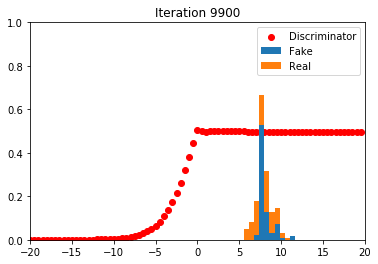

<IPython.core.display.Javascript object>

In [0]:
# We will store the losses here
g_losses = []
d_losses = []

# Training loop
n_samples = 100
epochs = 10000

grid = widgets.Grid(1, 1)

for e in range(epochs):
  # Get a random set of input noise
  noise = np.random.normal(0, 1, size=[n_samples, latent_dim])

  # Also get a sample from the 'real' distribution
  real = np.random.normal(real_mean, 1, size=[n_samples, latent_dim])

  # Generate some fake samples using the generator
  fake = generator.predict(noise)

  # Concatenate the fake and real images
  X = np.concatenate([real, fake])

  # Labels for generated and real data
  Y_dis = np.zeros(2*n_samples)
  
  # Set labels for real samples to 1
  Y_dis[:n_samples] = 1

  # Train discriminator with this batch of samples
  discriminator.trainable = True
  d_loss = discriminator.train_on_batch(X, Y_dis)
  d_losses.append(d_loss)
  
  # Train generator with a new batch of generated samples
  # Freeze the discriminator part
  discriminator.trainable = False 
  noise = np.random.normal(0, 1, size=[n_samples, latent_dim])
  # From the generator's perspective, the discriminator should predict
  # ones for all samples
  Y_gen = np.ones(n_samples)
  g_loss = gan.train_on_batch(noise, Y_gen)
  g_losses.append(g_loss)
  
  if e % 100 == 0:
    noise = np.random.normal(0, 1, size=[n_samples, latent_dim])
    fake = generator.predict(noise)        
    real = np.random.normal(real_mean, 1, size=[n_samples, latent_dim])
    pred = discriminator.predict(np.arange(-20, 20, 0.5).reshape((80, 1)))
    with grid.output_to(0, 0):
      grid.clear_cell()
      
      # plt.clf()
      pylab.hist((np.squeeze(fake), np.squeeze(real)), density=True, stacked=True)
      pylab.scatter(np.arange(-20, 20, 0.5), pred, c='r')     
      pylab.xlim(-20, 20)
      pylab.ylim(0, 1)
      pylab.title('Iteration {}'.format(e))
      pylab.legend(['Discriminator', 'Fake', 'Real'])
    time.sleep(0.5)
    
g_losses_normal_normal = g_losses
d_losses_normal_normal = d_losses

If all is well, the fake and real distributions should nicely overlap after training. The discriminator has essentially pushed the fake samples towards the real distribution and the generator is now able to transform the noise distribution into a distribution of 'real' samples!

**Question** Can you explain what happened to the red line during training? Why does it look like it does after training?

**Answer** *The discriminator classifies both real data and fake data from the generator. The discriminator loss reflects the distance between the distributions of these two. The discriminator in the plot shows the probability that the input data belongs to either the real dataset or the generated dataset. At first, the red line forms a sigmoid, which “pushes” the fake samples towards the real distribution. The closer the fake samples are to the real ones, the more linear the red line seems (central linear-like part of sigmoid, positive slope), across the range of samples (fake and real). Eventually, the fake samples get pushed slightly beyond the real samples, after which this line gets a negative slope, which pushes the fake samples back to the real ones. This line “wobbles” a couple of times, and then slowly stabilizes at 0.5
This corresponds to the probability of classifying the data right over the range for which samples are generated, and at this point the discriminator can no longer distinguish between real and fake samples, because fake samples will resemble real samples.*

**Question** Try training the GAN with different input noise distributions, e.g. uniform.

**Answer** *A plot is generated with a uniform noise distribution, the generator tries to resemble the real data with a uniform distribution as input. While with a uniform input noise distribution the generator cannot fully recreate the shape of the true distribution, but the sample range for the fake samples does same to correspond to the range of the true samples.*

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

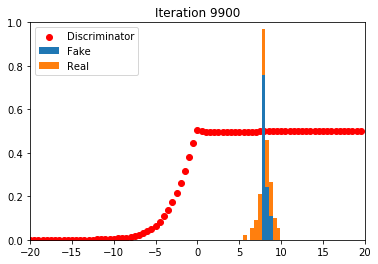

<IPython.core.display.Javascript object>

In [0]:
# We will store the losses here
g_losses = []
d_losses = []

# Training loop
n_samples = 100
epochs = 10000

grid = widgets.Grid(1, 1)

for e in range(epochs):
  # Get a random set of input noise
  noise = np.random.uniform(0, 1, size=[n_samples, latent_dim])

  # Also get a sample from the 'real' distribution
  real = np.random.normal(real_mean, 1, size=[n_samples, latent_dim])

  # Generate some fake samples using the generator
  fake = generator.predict(noise)

  # Concatenate the fake and real images
  X = np.concatenate([real, fake])

  # Labels for generated and real data
  Y_dis = np.zeros(2*n_samples)
  
  # Set labels for real samples to 1
  Y_dis[:n_samples] = 1

  # Train discriminator with this batch of samples
  discriminator.trainable = True
  d_loss = discriminator.train_on_batch(X, Y_dis)
  d_losses.append(d_loss)
  
  # Train generator with a new batch of generated samples
  # Freeze the discriminator part
  discriminator.trainable = False 
  noise = np.random.uniform(0, 1, size=[n_samples, latent_dim])
  # From the generator's perspective, the discriminator should predict
  # ones for all samples
  Y_gen = np.ones(n_samples)
  g_loss = gan.train_on_batch(noise, Y_gen)
  g_losses.append(g_loss)
  
  if e % 100 == 0:
    noise = np.random.uniform(0, 1, size=[n_samples, latent_dim])
    fake = generator.predict(noise)        
    real = np.random.normal(real_mean, 1, size=[n_samples, latent_dim])
    pred = discriminator.predict(np.arange(-20, 20, 0.5).reshape((80, 1)))
    with grid.output_to(0, 0):
      grid.clear_cell()
      
      # plt.clf()
      pylab.hist((np.squeeze(fake), np.squeeze(real)), density=True, stacked=True)
      pylab.scatter(np.arange(-20, 20, 0.5), pred, c='r')     
      pylab.xlim(-20, 20)
      pylab.ylim(0, 1)
      pylab.title('Iteration {}'.format(e))
      pylab.legend(['Discriminator', 'Fake', 'Real'])
    time.sleep(0.5)

**Question** See if you can find a distribution for the real samples for which the generator fails to generate samples.

**Answer** *If you concatenate 2 normal distributions with different means for the real samples, the generator will fail to resemble the real data. In this example, the real data contains 2 normal distributions with a mean value of 8 and -8.*
*Because the input distribution only consists of a single normal distribution, it cannot describe both normal distributions in the real data. Instead, only one of the distributions is fitted, and the Discriminator does not end at 0.5, but closer to 0.3, meaning that it thinks these samples are probably fake.*

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

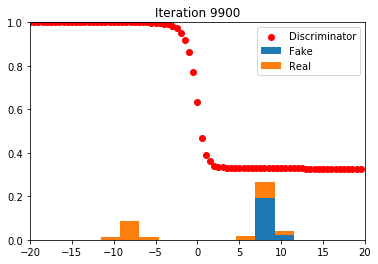

<IPython.core.display.Javascript object>

In [0]:
# We will store the losses here
g_losses = []
d_losses = []

# Training loop
n_samples = 100
epochs = 10000

grid = widgets.Grid(1, 1)

for e in range(epochs):
  # Get a random set of input noise
  noise = np.random.normal(0, 1, size=[n_samples, latent_dim])

  # Also get a sample from the 'real' distribution
  # real = np.random.normal(real_mean, 1, size=[n_samples, latent_dim])
  n_samples_1 = int(n_samples/2)
  n_samples_2 = n_samples - n_samples_1

  real_1 = np.random.normal(real_mean, 1, size=[n_samples_1, latent_dim])
  real_2 = np.random.normal(-real_mean, 1, size=[n_samples_2, latent_dim])
  real = np.concatenate([real_1, real_2])

  # Generate some fake samples using the generator
  fake = generator.predict(noise)

  # Concatenate the fake and real images
  X = np.concatenate([real, fake])

  # Labels for generated and real data
  Y_dis = np.zeros(2*n_samples)
  
  # Set labels for real samples to 1
  Y_dis[:n_samples] = 1

  # Train discriminator with this batch of samples
  discriminator.trainable = True
  d_loss = discriminator.train_on_batch(X, Y_dis)
  d_losses.append(d_loss)
  
  # Train generator with a new batch of generated samples
  # Freeze the discriminator part
  discriminator.trainable = False 
  noise = np.random.normal(0, 1, size=[n_samples, latent_dim])
  # From the generator's perspective, the discriminator should predict
  # ones for all samples
  Y_gen = np.ones(n_samples)
  g_loss = gan.train_on_batch(noise, Y_gen)
  g_losses.append(g_loss)
  
  if e % 100 == 0:
    noise = np.random.normal(0, 1, size=[n_samples, latent_dim])
    fake = generator.predict(noise)        
    #real = np.random.normal(real_mean, 1, size=[n_samples, latent_dim])
    real_1 = np.random.normal(real_mean, 1, size=[n_samples_1, latent_dim])
    real_2 = np.random.normal(-real_mean, 1, size=[n_samples_2, latent_dim])
    real = np.concatenate([real_1, real_2])

    pred = discriminator.predict(np.arange(-20, 20, 0.5).reshape((80, 1)))
    with grid.output_to(0, 0):
      grid.clear_cell()
      
      # plt.clf()
      pylab.hist((np.squeeze(fake), np.squeeze(real)), density=True, stacked=True)
      pylab.scatter(np.arange(-20, 20, 0.5), pred, c='r')     
      pylab.xlim(-20, 20)
      pylab.ylim(0, 1)
      pylab.title('Iteration {}'.format(e))
      pylab.legend(['Discriminator', 'Fake', 'Real'])
    time.sleep(0.5)

During training, we have stored the loss values for the discriminator and the generator. We can now plot these. Remember that for the digit classification task, we were looking for a set of parameters leading to a low loss function. 

**Question** The loss curves that you get look different. Can you explain why they're not nicely dropping to zero?

**Answer** *The objective function for the discriminator has to be maximized. It consists of two parts, the discriminator is trained to correctly classify real and fake images by maximizing the log of predicted probability of real samples and minimizing (inverse log) the log of predicted probability of synthetic samples. If the discriminator would drop to 0, it would be able to distinguish between real and fake samples, which is not what we want. If the generator would drop to 0.*

**Question** Can you explain the loss in the discriminator based on the objective function of the discriminator?

**Answer** *The generator is generating data that resembles the real data, so the probability of classifying samples to either real or fake data equals 0,5. So we fill this in for the negative log-likelihood, which makes $-log(D(x)) = -log(0.5) \approx 0.693$. So the loss function converges to this value*

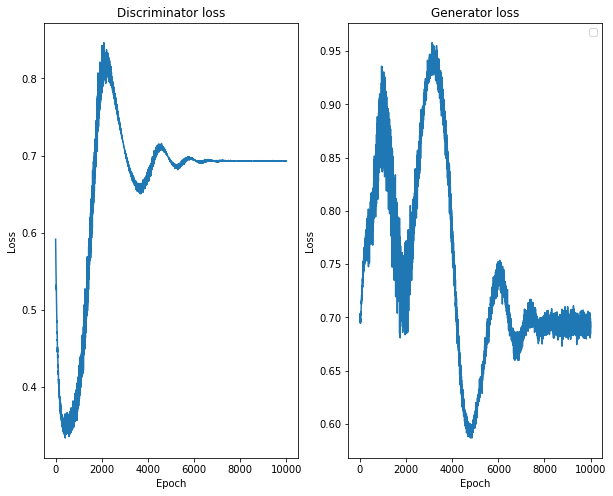

In [0]:
# Use the losses from the first run
g_losses = g_losses_normal_normal
d_losses = d_losses_normal_normal

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(d_losses)
plt.title('Discriminator loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(g_losses)
plt.title('Generator loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Although it is definitely nice that we can train two networks together to learn the distribution of a real data distribution, generating samples from a normal distribution is in itself not really interesting. Luckily, we can use the same principles to generate images.

# MNIST synthesis
Like last week, we are again going to use MNIST data. Data preparation is the same as before.

In [0]:
from keras.datasets import mnist
from keras.utils import to_categorical

# load the MNIST the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# scale the image intensities to the 0-1 range
x_train = (x_train / 255.0).astype(np.float32)
x_test = (x_test / 255.0).astype(np.float32)

# convert the data to channel-last
train_set_images = np.expand_dims(x_train, axis=-1)
test_set_images = np.expand_dims(x_test, axis=-1)

# convert the labels to one-hot encoded
train_set_labels = to_categorical(y_train, num_classes=10)
test_set_labels = to_categorical(y_test, num_classes=10)

11493376/11490434 [==============================] - 2s 0us/step


Plot some images.

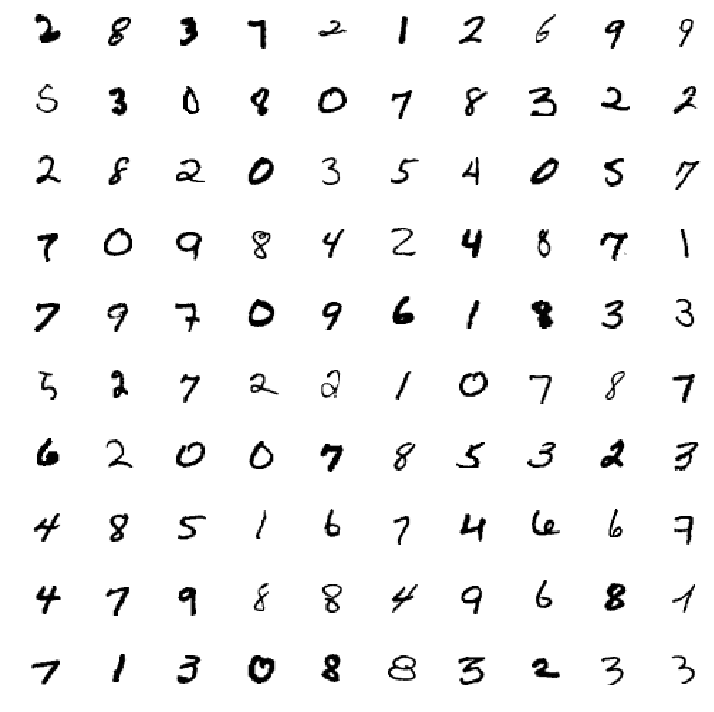

In [0]:
def plotImages(images, dim=(10, 10), figsize=(10, 10), title=''):
    plt.figure(figsize=figsize)
    for i in range(images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()
    
plotImages(train_set_images[np.random.randint(0, train_set_images.shape[0], size=100)].reshape(100, 28, 28))

In last week's exercise you have built a discriminative model that was able to classify an image into one of ten digit categories. In this exercise, we are going to do the inverse. Given a point in a latent space (which in our case will be a multi-dimensional Gaussian distribution), we are going to train the network to generate a realistic digit image for this point. The MNIST data set will be used as a set of real samples. 

<img src="https://skymind.ai/images/wiki/GANs.png">



## The discriminator
As you can see in the image above, we will need a generator and a discriminator network. Let's define these. Consider the network that you used
for digit classification in the previous exercise and see if you can spot some differences between that network and the network below.

**Question** Is this a convolutional neural network? Why (not)?

**Answer** *No, this network is not convolutional, because it does not contain any convolutional layers. It only contains dense layers, which are just regular layers of neurons in a neural network. Each neuron receives input from all the neurons in the previous layer. The Leaky RelU layers are activation layers for the dense layers. So this network is just a regular neural network, a multilayer perceptron.*



In [0]:
def get_discriminator_MLP():
  discriminator = keras.models.Sequential()
  discriminator.add(Dense(1024, input_dim=784, kernel_initializer=keras.initializers.RandomNormal(stddev=0.02)))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dropout(0.3))
  discriminator.add(Dense(512))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dropout(0.3))
  discriminator.add(Dense(256))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dense(1, activation='sigmoid'))
  return discriminator

You could argue that digits are a bit more complex than samples from a Gaussian distribution, so let's set the latent space dimensionality for noise sampling a bit higher than 1.

In [0]:
latent_dim = 10


## The generator

The generator is different than the discriminator. It should go from a low-dimensional noise vector to an MNIST image.

In [0]:
def get_generator_MLP():
  generator = keras.models.Sequential()
  generator.add(Dense(256, input_dim=latent_dim, kernel_initializer=keras.initializers.RandomNormal(stddev=0.02)))
  generator.add(LeakyReLU(0.2))
  generator.add(Dense(512))
  generator.add(LeakyReLU(0.2))
  generator.add(Dense(1024))
  generator.add(LeakyReLU(0.2))
  generator.add(Dense(784, activation='tanh'))
  return generator

**Question** Consider the activation functions of the output layers of the generator and discriminator networks. How are they different?

**Answer**
*In the output layers of the generator the activation function is the tanh function. In the discriminator network the activation function is the sigmoid function. Sigmoid is a smooth step function with values between 0 and 1, and tanh is a function with values between -1 and 1. Tanh is a scaled sigmoid function.*

**Question** Also look at the activation functions of the other layers, can you find out what they do? Look at the Keras documentation.
 
 **Answer**
*The activation functions for the dense layers are the advanced activation LeakyRelU. This function is similar to the RelU function, however it causes a leak by changing the slope left of x=0. This extends the range of RelU. The function is non-linear and has output 0 if the input is less than 0, and raw output otherwise.*

## The model
Now  let's combine the generator and the discriminator. We train both using a binary crossentropy objective. This is very similar to what we did before.

In [0]:
discriminator = get_discriminator_MLP()
generator = get_generator_MLP()

discriminator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))
generator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))

discriminator.trainable = False
z = keras.layers.Input(shape=(latent_dim,))
G_z = generator(z)
D_G_z = discriminator(G_z)
gan = keras.models.Model(inputs=z, outputs=D_G_z)
gan.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))

Some helper functions.

In [0]:
def saveModels(epoch):
    generator.save('gan_generator_epoch_{}.h5'.format(epoch))
    discriminator.save('gan_discriminator_epoch_{}.h5'.format(epoch))
    
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, latent_dim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle('Epoch {}'.format(epoch))
    plt.show()

Run the code below to train the GAN model. Synthesized images should be shown periodically. 

In [0]:
d_losses = []
g_losses = []

epochs = 200
batch_size = 128

X_train = (train_set_images.reshape(60000, 784).astype(np.float32) - 0.5)/0.5

batch_count = int(X_train.shape[0] / batch_size)
for e in range(epochs):
  for _ in range(batch_count):

    # Get a random set of input noise and images
    noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
    image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]

    # Generate some fake MNIST images using the generator
    generated_images = generator.predict(noise)

    # Concatenate the fake and real images
    X = np.concatenate([image_batch, generated_images])

    # Labels for generated and real data
    y_dis = np.zeros(2*batch_size)
    # One-sided label smoothing
    y_dis[:batch_size] = 0.9

    # Train discriminator with this batch of samples
    discriminator.trainable = True
    d_loss = discriminator.train_on_batch(X, y_dis)

    # Train generator with a new batch of generated samples
    noise = np.random.normal(0, 1, size=[batch_size, latent_dim])

    # From the generator's perspective, the discriminator should predict
    # ones for all samples
    y_gen = np.ones(batch_size)

    # Freeze the discriminator part
    discriminator.trainable = False

    # Train the GAN to predict ones
    g_loss = gan.train_on_batch(noise, y_gen)

  # Store loss of most recent batch from this epoch
  d_losses.append(d_loss)
  g_losses.append(g_loss)

  if e % 5 == 0:
    noise = np.random.normal(0, 1, size=[100, latent_dim])
    plotGeneratedImages(e)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(0.001)
    saveModels(e)

<Figure size 432x288 with 0 Axes>

**Question** Inspect the loss curves for this model and explain what happens.

**Answer** *The loss function of the discriminator are inverted seeking probabilities close to 1.0 for real images and probabilities close to 0.0 for fake images. The addition of these values means that lower average values of this loss function result in better performance of the discriminator. As visible in the figures below, the discriminator has increasing error. This means that it is harder for the discriminator to distinguish the real from the generated images.*

*The loss function of the generator is minimizing the log of the inverted probability of the discriminator's prediction of fake images, averaged over a mini-batch. It is clearly visible that the loss decreases over training. This means that the generated figures are better.*

*In the figures below you can see that in both loss functions the value is converging to a specific value over training.*



No handles with labels found to put in legend.


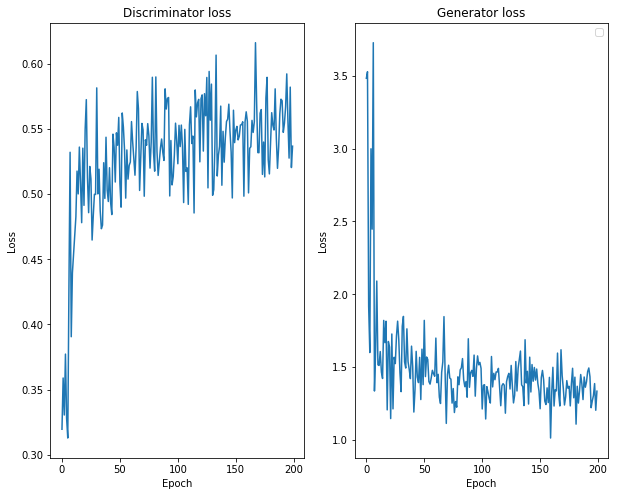

In [0]:
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(d_losses)
plt.title('Discriminator loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(g_losses)
plt.title('Generator loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## A convolutional model
Thus far the discriminator and generator were both multilayer perceptrons. Now we're going to add in some convolutional layers to turn them into a deep convolutional GAN (<a href="http://arxiv.org/abs/1511.06434">DCGAN</a>)-like architecture. This means that we have to redefine the generator network and a discriminator network. 

The discriminator network is (almost) the same network that we used in last week's exercise.

In [0]:
from keras.layers.convolutional import Conv2D, UpSampling2D

def get_discriminator_CNN():
  discriminator = keras.models.Sequential()
  discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(1, 28, 28), kernel_initializer=keras.initializers.RandomNormal(stddev=0.02)))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dropout(0.3))
  discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dropout(0.3))
  discriminator.add(Flatten())
  discriminator.add(Dense(1, activation='sigmoid'))
  return discriminator

def get_generator_CNN():
  generator = keras.models.Sequential()
  generator.add(Dense(128*7*7, input_dim=latent_dim, kernel_initializer=keras.initializers.RandomNormal(stddev=0.02)))
  generator.add(LeakyReLU(0.2))
  generator.add(Reshape((128, 7, 7)))
  generator.add(UpSampling2D(size=(2, 2)))
  generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
  generator.add(LeakyReLU(0.2))
  generator.add(UpSampling2D(size=(2, 2)))
  generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))
  return generator

Let's build our model like before.

In [0]:
discriminator = get_discriminator_CNN()
generator = get_generator_CNN()

discriminator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))
generator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))

discriminator.trainable = False
z = keras.layers.Input(shape=(latent_dim,))
x = generator(z)
D_G_z = discriminator(x)
gan = keras.models.Model(inputs=z, outputs=D_G_z)
gan.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))

Train the model using the code below. Inspect the samples that come out. 

**Question** What are some differences between these samples and the ones generated by the multilayer perceptron GAN? Can you explain these differences?

**Answer** *The one below is computationally more expensive (certainly much slower) than the MLP GAN, but the images are more clear in early epochs. Less noise is seen in the images. The background is white instead of noisy. When we take a look at the loss curves, we can see that the range of the y axis, the range for the loss, is very small compared to the range in the MLP GAN. The first loss of the discriminator is already quite high. It might be considered converged immediately at the start of training and it is hard to consider when training has ended.*

In [0]:
d_losses = []
g_losses = []

epochs = 200
batch_size = 128

X_train = (train_set_images.reshape(60000, 1, 28, 28).astype(np.float32) - 0.5)/0.5

batch_count = int(X_train.shape[0] / batch_size)
for e in range(epochs):
  for _ in range(batch_count):
    # Get a random set of input noise and images
    noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
    image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]

    # Generate some fake MNIST images using the generator
    generated_images = generator.predict(noise)

    # Concatenate the fake and real images
    X = np.concatenate([image_batch, generated_images])

    # Labels for generated and real data
    y_dis = np.zeros(2*batch_size)
    # Set reference to 1 for real samples
    y_dis[:batch_size] = 1

    # Train discriminator with this batch of samples
    discriminator.trainable = True
    d_loss = discriminator.train_on_batch(X, y_dis)

    # Train generator with a new batch of generated samples
    noise = np.random.normal(0, 1, size=[batch_size, latent_dim])

    # From the generator's perspective, the discriminator should predict
    # ones for all samples
    y_gen = np.ones(batch_size)

    # Freeze the discriminator part
    discriminator.trainable = False

    # Train the GAN to predict ones
    g_loss = gan.train_on_batch(noise, y_gen)

    # Store loss of most recent batch from this epoch
  d_losses.append(d_loss)
  g_losses.append(g_loss)

  if e % 5 == 0:
    noise = np.random.normal(0, 1, size=[100, latent_dim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(100, 28, 28)          
    plotImages(generatedImages, title='Epoch {}'.format(e))
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(0.001)    
    saveModels(e)

<Figure size 432x288 with 0 Axes>

No handles with labels found to put in legend.


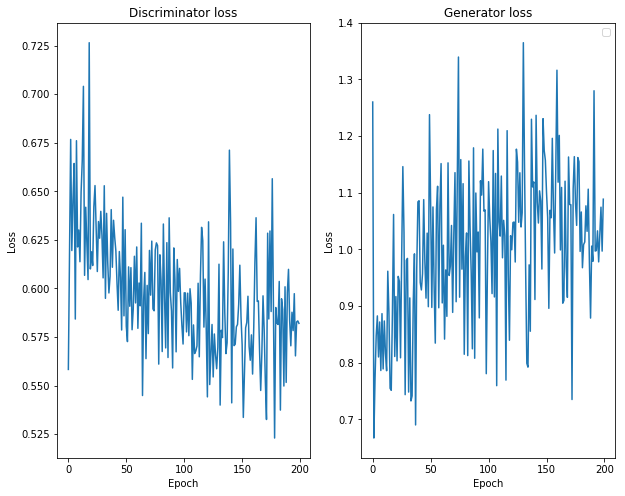

In [0]:
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(d_losses)
plt.title('Discriminator loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(g_losses)
plt.title('Generator loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Interpolation in the latent space
We're going to explore the latent space a bit more. We pick two points in the latent space and make a linear interpolation between these two. Then we generate images from each of the interpolated latent points. 

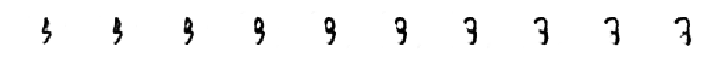

In [0]:

latent_dim=10
noise_a = np.random.normal(0, 1, size=[1, latent_dim])
noise_b = np.random.normal(0, 1, size=[1, latent_dim])

noise = np.zeros((10, latent_dim), dtype='float32')
for ni in range(10):
  noise[ni, :] = float(ni)/10. * noise_a + (1 - float(ni)/10.) * noise_b
generatedImages = generator.predict(noise)
generatedImages = generatedImages.reshape(10, 28, 28)          
plotImages(generatedImages, dim=(1, 10), figsize=(10, 10))

**Question** Explain what you see in this plot.

**Answer** *Linear interpolation of the latent space between two points (two noise vectors). The first figure is the representation of the noise vector b and the last figure is the noise vector a. The figures in between are steps where noise vector a and noise vector b are both taken into account. In the first figure noise vector a is 0% (not) taken into account, and in the last vector noise vector a is 100% taken into account. Each step vector b is 10% less and vector a is 10% more taken into account.*

**Question** What happens when you extrapolate out of the latent space distribution? Consider how the noise vectors are drawn.

**Answer** *Unfortunately, there was not enough time left to run this. Implementation would be done by changing the noise distribution, for example:
noise = np.random.normal(0, 1, size=[batch_size, latent_dim]) --> noise = np.random.uniform(3, 4, size=[batch_size, latent_dim])
Which would give a distribution that is very different that the ones the GAN is "used" to. It is unlikely that this would recognizable images.*

In [0]:
d_losses = []
g_losses = []

epochs = 200
batch_size = 128

X_train = (train_set_images.reshape(60000, 1, 28, 28).astype(np.float32) - 0.5)/0.5

batch_count = int(X_train.shape[0] / batch_size)
for e in range(epochs):
  for _ in range(batch_count):
    # Get a random set of input noise and images
    noise = np.random.uniform(3, 4, size=[batch_size, latent_dim])
    image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]

    # Generate some fake MNIST images using the generator
    generated_images = generator.predict(noise)

    # Concatenate the fake and real images
    X = np.concatenate([image_batch, generated_images])

    # Labels for generated and real data
    y_dis = np.zeros(2*batch_size)
    # Set reference to 1 for real samples
    y_dis[:batch_size] = 1

    # Train discriminator with this batch of samples
    discriminator.trainable = True
    d_loss = discriminator.train_on_batch(X, y_dis)

    # Train generator with a new batch of generated samples
    noise = np.random.uniform(3, 4, size=[batch_size, latent_dim])

    # From the generator's perspective, the discriminator should predict
    # ones for all samples
    y_gen = np.ones(batch_size)

    # Freeze the discriminator part
    discriminator.trainable = False

    # Train the GAN to predict ones
    g_loss = gan.train_on_batch(noise, y_gen)

    # Store loss of most recent batch from this epoch
  d_losses.append(d_loss)
  g_losses.append(g_loss)

  if e % 5 == 0:
    noise = np.random.uniform(3, 4, size=[batch_size, latent_dim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(100, 28, 28)          
    plotImages(generatedImages, title='Epoch {}'.format(e))
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(0.001)    
    saveModels(e)

# Histopathology image synthesis

Now we're going to synthesize some actual images. We're going to use the PatchCamelyon data set ([more info here](https://github.com/basveeling/pcam)) which consists of small images that can be used for classification benchmarks. Today, we're not going to classify images, but we're going to synthesize them. You can download a data set of smaller (28 x 28 pixels) versions of these images from 
[this link](https://filesender.surf.nl/?s=download&token=09f710b3-25f6-43f6-b554-5162390494e2). Upload the data set in the dialog below.

In [0]:
uploaded = files.upload()

Now load the data set.

In [0]:
def loadPatchCamelyon(path):    
    f = gzip.open(path, 'rb')
    train_set = pickle.load(f, encoding='latin1')
    f.close()
    return train_set

In [0]:
train_set_images = loadPatchCamelyon(r'valid_28.pkl.gz')

def plotImagesPatchCamelyon(images, dim=(10, 10), figsize=(10, 10), title=''):
    plt.figure(figsize=figsize)
    for i in range(images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()
    
    
plotImagesPatchCamelyon(train_set_images[np.random.randint(0, train_set_images.shape[0], size=100)].reshape(100, 28, 28, 3)/255.0)

What do you immediately notice? Indeed, these images are in color! So the generator will have to generate three output channels instead of just one. 

In this second-to-last part of the practical you're going to repurpose the code that you have used so far to synthesize histopathology images like the ones above. You can play around a bit with this, see what happens when you interpolate between samples, etc. Remember that there is a final 'exercise' below.

**Good luck!**

**Answer** *Due to the RBG channels in coloured images, the discriminator and generator had to be adjusted so it could accomodate these new channel inputs. Furthermore, the shape had to be adjusted so it had the correct input shape for the training cycle. The plotting of the data is unfortunately not completed. Multiple adjustments were made to accomondate the different RBG channels in the plotting code with quite a bit of bugfixing; however, the images that were generated were very pixelated in the early stages of the epochs and due to the extremely long runtime on this pc(10 epochs could take an hour) later stage epochs weren't able to be checked and thus unfortunately the code could not be verified whether it was working properly.*

In [0]:
import pickle
import gzip
import numpy as np
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers import DepthwiseConv2D
import keras
from keras.layers.advanced_activations import LeakyReLU
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import pylab
from IPython import display
import tensorflow as tf
keras.backend.set_image_data_format('channels_first')
from keras.layers.convolutional import Conv2D, UpSampling2D
import time
import random
random.seed(0)
from keras.layers.convolutional import Conv2D, UpSampling2D

def get_discriminator_CNN():
  discriminator = keras.models.Sequential()
  discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(3, 28, 28), kernel_initializer=keras.initializers.RandomNormal(stddev=0.02))) #input shape 3 instead of 1 because its a RBG image.
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dropout(0.3))
  discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dropout(0.3))
  discriminator.add(Flatten())
  discriminator.add(Dense(1, activation='sigmoid'))
  return discriminator

def get_generator_CNN():
  generator = keras.models.Sequential()
  generator.add(Dense(128*7*7, input_dim=latent_dim, kernel_initializer=keras.initializers.RandomNormal(stddev=0.02)))
  generator.add(LeakyReLU(0.2))
  generator.add(Reshape((128, 7, 7)))
  generator.add(UpSampling2D(size=(2, 2)))
  generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
  generator.add(LeakyReLU(0.2))
  generator.add(UpSampling2D(size=(2, 2)))
  generator.add(Conv2D(3, kernel_size=(5, 5), padding='same', activation='tanh')) #3 instead of 1.
  return generator

def loadPatchCamelyon(path):    
    f = gzip.open(path, 'rb')
    train_set = pickle.load(f, encoding='latin1')
    f.close()
    return train_set


def plotImagesPatchCamelyon(images, dim=(10, 10), figsize=(10, 10), title=''):
    plt.figure(figsize=figsize)
    for i in range(images.shape[0]):
        print(images.shape[0])
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(images[i,:,:,:], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()
  
    
def plotImages(images, dim=(10, 10), figsize=(10, 10), title=''):
    plt.figure(figsize=figsize)
    for i in range(images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()    
    
def saveModels(epoch):
    generator.save('gan_generator_epoch_{}.h5'.format(epoch))
    discriminator.save('gan_discriminator_epoch_{}.h5'.format(epoch))

    
#Load the images.    
#train_set_images = loadPatchCamelyon(r'./valid_28.pkl.gz')
    
#Plot the images
#plotImagesPatchCamelyon(train_set_images[np.random.randint(0, train_set_images.shape[0], size=100)].reshape(100, 28, 28, 3)/255.0)



#The model
real_mean = 8
latent_dim = 1

discriminator = get_discriminator_CNN()
generator = get_generator_CNN()

discriminator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))
generator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))

discriminator.trainable = False
z = keras.layers.Input(shape=(latent_dim,))
x = generator(z)
D_G_z = discriminator(x)

gan = keras.models.Model(inputs=z, outputs=D_G_z)
gan.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))

d_losses = []
g_losses = []

epochs = 5
batch_size = 4000


#X_train = (train_set_images.reshape(60000, 1, 28, 28).astype(np.float32) - 0.5)/0.5
X_train = (np.transpose(train_set_images, (0, 3, 1, 2)).astype(np.float32) - 0.5)/0.5 #reshape the input

batch_count = int(X_train.shape[0] / batch_size)
for e in range(epochs):
  for _ in range(batch_count):
    # Get a random set of input noise and images
    noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
    image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]

    # Generate some fake MNIST images using the generator
    generated_images = generator.predict(noise)

    # Concatenate the fake and real images
    X = np.concatenate([image_batch, generated_images])

    # Labels for generated and real data
    y_dis = np.zeros(2*batch_size)
    # Set reference to 1 for real samples
    y_dis[:batch_size] = 1

    # Train discriminator with this batch of samples
    discriminator.trainable = True
    d_loss = discriminator.train_on_batch(X, y_dis)

    # Train generator with a new batch of generated samples
    noise = np.random.normal(0, 1, size=[batch_size, latent_dim])

    # From the generator's perspective, the discriminator should predict
    # ones for all samples
    y_gen = np.ones(batch_size)

    # Freeze the discriminator part
    discriminator.trainable = False

    # Train the GAN to predict ones
    g_loss = gan.train_on_batch(noise, y_gen)

    # Store loss of most recent batch from this epoch
  d_losses.append(d_loss)
  g_losses.append(g_loss)


  if e % 5 == 0:
    noise = np.random.normal(0, 1, size=[100, latent_dim])
    generatedImages = generator.predict(noise)
    print(generated_images.shape)
    generatedImages = generatedImages.reshape(100, 28, 28,3)          
    plotImages(generatedImages, title='Epoch {}'.format(e))
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(0.001)    
    saveModels(e)

# Conditional image synthesis

## The BigGAN model
The images we have synthesized so far are all quite small. Synthesis of larger images (e.g. 512 x 512 pixels) typically requires a lot of compute power and patience. Unfortunately, you don't have 100s of GPU at your disposal (I guess) to train a model like BigGAN, the state of the art in conditional image synthesis. A wild guess is that it would cost you around [USD60000](https://twitter.com/quasimondo/status/1065610256917692416) to train this model.

Luckily, the authors of BigGAN have put a version of their pretrained model online and you can use it to synthesize images. Go to [this Colaboratory file](https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/biggan_generation_with_tf_hub.ipynb) and answer the following questions.

**Question** What happens when you change the noise seed? Also try out different categories.

*All images folders mentioned for the following answers are in the folder BigGAn* 

**Answer** *Different images are generated, with the same subject. Changing the noise seed changes the random input on which the images are based.*
*Example images are in the folder "noise_seed images", with name format [category]\_noiseis[noise_seed]*

**Question** What happens to your samples when you change the truncation value? More precisely, what happens to the diversity and the quality of your samples? Take a look at the [paper on arXiv](https://arxiv.org/abs/1809.11096) Sec. 3.1 to get an idea what this value does.

**Answer** *“Truncation the z vector by resampling the values with magnitude above the chosen threshold leads to improvement in individual sample quality at the cost of reduction in overall sample variety”. i.e. Low truncation value result in very similar (low magnitude for z), but higher quality images while high truncation values give different looking images of lower quality.*

*For example images, see the folder "truncation images", with name format [category\_truncationis[truncation value without dot, so 02 and 04 are actually 0.2 and 0.4]*

*The low truncation value of 0.2 shows the fox in a similar pose and background, while a high truncation value of 1 shows many different backgrounds, lightings and poses. But some of these don’t look quite right, e.g. an extra ear for the 3rd, the head size of 5th image (you could even say the green background makes no sense for an arctic fox in full winter coat, but that might be a bit of a stretch). And of course, the truncation value of 0.4 shows a compromise.*

**Question** Interpolate between image categories, inspect what these look like. 
**Answer** *The subject of the images gradually transitions form one category to the next, this includes the background and position.*

*Some fun examples are in the folder "interpolate images":*
* *pug-wolf.png (Pug (254) to gray wolf (269)) lets these poor pugs return to their roots, so they may once again be able to breath properly again*
* *pug-persian.png (Pug (254) to Persian cat (283))creates the ultimate flat-faced pet monstrosity*
* *persian-snow-leopard.png (Persian cat (283) to Snow leopard (289)) also gives breathing space back to the persian*
* *persian-pomeranian.png (Persian cat (283) to Pomeranian (259)) Some people cannot choose between a cat or a dog, this tries to create the ultimate fluffy pet for them*
* *tabby-golden-retriever.png (Tabby cat (281) to Golden Retriever (207)) gives a shorter-haired variant for them*

*Because cats and dogs are quite similar, the transition looks fairly OK. However, if the categories are very different, it does not work. For example, if you try to change the fastest animal on land into a fast car, you get a mess, as can be seen on the image cheetah-race-car.png (Cheetah (293) to Race car (751))*

## Conditional MNIST synthesis
For all MNIST samples we already have labels (0, 1, ..., n). Try to change the MNIST synthesis code such that you can ask the generator to generate specific labels. I.e., try to train a conditional GAN. You can look for some inspiration in [this paper](https://arxiv.org/pdf/1411.1784.pdf), in particular Sec. 4.1. Remember that you already got the MNIST labels when loading the data set.

**Answer** *The idea behind a conditional GAN is to add an additional one-hot encoded vector y to both the generator and the discriminator as input.*

*Implementation was not successful. A few steps that were taken are described below:*

*The convolutional model was chosen to try to implement the conditional image generation, because this sems to be the standard.*
*To add y to the generator, this vector could simply be concatenated to the noise vector. But for the discriminator, the original input are of an image size, so a vector cannot simply be added.*

*Based on [this tutorial](https://medium.com/@ma.bagheri/a-tutorial-on-conditional-generative-adversarial-nets-keras-implementation-694dcafa6282) (and corresponding code from [here](https://github.com/mabagheri/CGAN/blob/master/cgan_Keras.py)\), 2 layers were added at the start of the discriminator that would first embed the vector y to the input image size. Implementing this part seems successful (at least runs error-free).*
*However, while the same setup was followed for the generator, something breaks here. The error could not be found.*

*The non-functioning code can be examined in code/conditional_MNIST_attempt.py*

# Pretrained models

You can download some pre-trained generator models for the GAN training exercises from [this link](https://filesender.surf.nl/?s=download&token=475362bb-4098-4376-979b-b0d3ae9e3dd0), but of course it's much more interesting to train them yourself. Use 


```
generator = keras.models.load_model(filename)
```

to load the model.


In [0]:
generator = keras.models.load_model()